<a href="https://colab.research.google.com/github/ChecinskiBartlomiej/UM/blob/main/UM_hw_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Understanding Splitting Criteria in CART for Regression**
---------------------

In this assignment, you will explore three common formulations of the splitting criterion used in **CART (Classification and Regression Trees)** for **regression problems**:

1. **Local RSS Minimization**  
2. **RSS Gain Maximization**  
3. **Total RSS Minimization**

You will investigate whether any of these criteria are equivalent, and you will design an experiment to determine which criterion is actually employed in a standard implementation such as **scikit-learn’s DecisionTreeRegressor**.



## **The Problem**

Many treatments of CART for regression describe the split selection process in different ways. Below are three frequently cited formulations. Suppose we have a dataset with features $X$ and target $y$, and we seek to choose a feature $X_j$ and a threshold $t$ to split the data into two regions $R_1(X_j, t)$ and $R_2(X_j, t)$. Denote by $\bar{y}_{R_m}$ the mean of targets within region $R_m$.

1. **Local RSS Minimization**  
   We select the feature and threshold that minimize the **sum of squared errors** in the two resulting child nodes:
   $$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$

2. **RSS Gain Maximization**  

   It is also a local method, looking only at a parent and two child nodes.

   We select the feature and threshold that maximize the **reduction** in RSS, computed by subtracting the RSS of the two child nodes from the RSS in the parent node:
   $$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Parent}} (y_i - \bar{y})^2}_{\text{Parent RSS}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Children RSS}}
   \Bigr\}.
   $$

3. **Total RSS Minimization**  
   For a dataset $\{(x_i, y_i)\}_{i=1}^N$ with features $X$ and target $y$, let $T$ be the current tree.

   For any split on feature $X_j$ at threshold $t$, define $T(X_j, t)$ as the new tree obtained by splitting one leaf of $T$ into two leaves $R_1(X_j, t)$ and $R_2(X_j, t)$.
   
   Let $\mathrm{Leaves}(T(X_j, t))$ be the set of all leaf indices in this new tree. For each leaf $m \in \mathrm{Leaves}(T(X_j, t))$, define:
   $$
   R_m = \{\, i \,\mid\, x_i \text{ ends in leaf } m\}.
   $$

   $R_m$ set collects all data indices $i$ whose feature vector $x_i$ is classified into the leaf node $m$ when passed through the tree $T(X_j,t)$. In other words, each leaf node $m$ in $T(X_j, t)$ corresponds to a unique path of splits, and any data point $x_i$ that follows that path is assigned to the leaf $m$; hence, it belongs to $R_m$.

   $R_m$ sets for all leafs $m \in \mathrm{Leaves}(T(X_j, t))$ define a partition of all indices.

   Then the objective of **minimizing total Residual Sum of Squares (total RSS)** is stated as:
   $$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))}
   \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2,
   $$
   where
   $$
   \overline{y}_{R_m} = \frac{1}{\lvert R_m \rvert}
   \sum_{i \in R_m} y_i
   $$
   is the mean response in leaf $m$.


## **Research Questions**

1. **Equivalence Analysis**  
   Determine whether the above formulations are equivalent or if they can yield different split choices. Specifically:
   - Are *local RSS minimization* and *RSS gain maximization* equivalent?
   - Does *total RSS minimization* coincide with either of these two, or is it distinct?
   
2. **Empirical Experiment**  
   Design and conduct a Python experiment to determine which of these formulations is implemented in `scikit-learn` in `DecisionTreeRegressor`. Present numerical results and plots to support your conclusion.


## **Tasks & Deliverables**

1. **Formulation Analysis**  
   - Compare *local RSS minimization*, *RSS gain maximization*, and *total RSS minimization*.
   - If you find that any pair of formulations is equivalent, provide a concise proof.  
   - If you find that they differ, construct a counterexample.

2. **Empirical Verification**  
   - Create a small artificial dataset and train a `DecisionTreeRegressor` from `scikit-learn`.
   - The dataset must be designed in a way that uniquely identifies the formulation used. Provide a short code snippet and a plot or table to support your conclusion.

3. **Report**  
   - Summarize your theoretical insights and empirical findings in a **Colab notebook**.
   - Include the relevant proofs, code, discussion, and conclusions.
   - Place the notebook in your **GitHub repository** for this course, add a link to it in your README.md and add an **“Open in Colab”** badge in the notebook so it can be launched directly.



I will begin by showing that the two methods are not equivalent. To illustrate this, consider the data pairs {(1,1), (2,2), (6,6), (7,7), (8,8)}—where the first coordinate represents the feature and the second the label. Since both coordinates are identical in each pair, I will refer to each pair using a single number.

In [1]:
import numpy as np

def compute_ssr(y):
    """
    Oblicza sumę kwadratów odchyleń (SSR) od średniej.
    """
    mean_y = np.mean(y)
    return np.sum((y - mean_y) ** 2)

# Local RSS minimization.
def split1(X):
    best_ssr = float('inf')
    best_split = None

    for i in range(1, len(X)):
        threshold = (X[i - 1] + X[i]) / 2

        left_mask = X < threshold
        right_mask = X >= threshold

        ssr_left = compute_ssr(X[left_mask])
        ssr_right = compute_ssr(X[right_mask])
        total_ssr = ssr_left + ssr_right

        if total_ssr < best_ssr:
            best_ssr = total_ssr
            best_split = threshold
    return best_split, best_ssr

# RSS Gain Maximization.
def split2(X):
    best_gain = -float('inf')
    best_split = None
    for i in range(1, len(X)):
        threshold = (X[i-1] + X[i]) / 2

        left_mask = X < threshold
        right_mask = X >= threshold

        ssr_parent = compute_ssr(X)
        ssr_left = compute_ssr(X[left_mask])
        ssr_right = compute_ssr(X[right_mask])
        gain = ssr_parent - ssr_left - ssr_right

        if gain > best_gain:
            best_gain = gain
            best_split = threshold
    return best_split, best_gain

X = np.array([1, 2, 6, 7, 8])

# Build shallow tree using method 1.
print("Tree 1:")

# First split.
t_1 = split1(X)[0]
X_1_l = X[X < t_1]
X_1_r = X[X >= t_1]
print(X_1_l)
print(X_1_r)

# Second split.
if split1(X_1_l)[1] < split1(X_1_r)[1]:
    t_2 = split1(X_1_l)[0]
    X_2_l = X_1_l[X_1_l < t_2]
    X_2_r = X_1_l[X_1_l >= t_2]
else:
    t_2 = split1(X_1_r)[0]
    X_2_l = X_1_r[X_1_r < t_2]
    X_2_r = X_1_r[X_1_r >= t_2]

print(X_2_l)
print(X_2_r)

# Build shallow tree using method 2.

print("Tree 2:")
# First split.
s_1 = split2(X)[0]
Z_1_l = X[X < t_1]
Z_1_r = X[X >= t_1]
print(Z_1_l)
print(Z_1_r)

# Second split.
if split2(Z_1_l)[1] > split2(Z_1_r)[1]:
    s_2 = split2(Z_1_l)[0]
    Z_2_l = Z_1_l[Z_1_l < t_2]
    Z_2_r = Z_1_l[Z_1_l >= t_2]
else:
    t_2 = split2(Z_1_r)[0]
    Z_2_l = Z_1_r[Z_1_r < t_2]
    Z_2_r = Z_1_r[Z_1_r >= t_2]

print(Z_2_l)
print(Z_2_r)

Tree 1:
[1 2]
[6 7 8]
[1]
[2]
Tree 2:
[1 2]
[6 7 8]
[6]
[7 8]


As we can see two algorithms picked different node at the second split.

Now I will prove equivalence of second and third method. This also means that first and third methods are not equivalent.

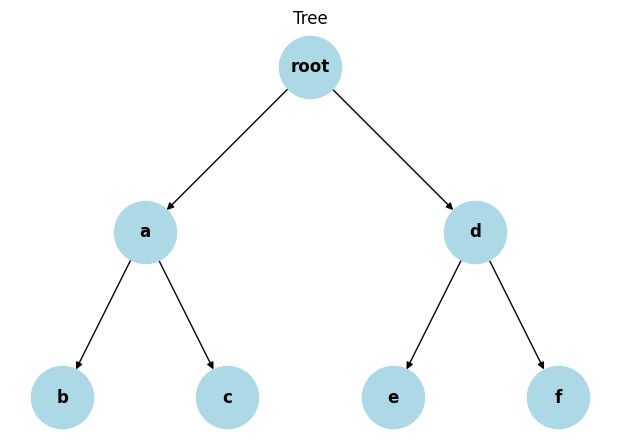

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Draw a tree.
G = nx.DiGraph()
G.add_edge("root", "a")
G.add_edge("root", "d")
G.add_edge("a", "b")
G.add_edge("a", "c")
G.add_edge("d", "e")
G.add_edge("d", "f")
pos = {
    "root": (0, 0),
    "a": (-1, -1),
    "d": (1, -1),
    "b": (-1.5, -2),
    "c": (-0.5, -2),
    "e": (0.5, -2),
    "f": (1.5, -2)
}
plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=2000, node_color="lightblue", font_size=12, font_weight="bold")
plt.title("Tree")
plt.axis("off")
plt.show()


Assume that the letters represent the RSS value at each node. Now, suppose that nodes b,c,e,f have not yet been formed, and we need to decide which split to choose. Consider splitting at node a. For the second method to select node
a for the split, the inequality
$$a-b-c>d-e-f$$
must hold. In contrast, for the third method, the condition is
$$b+c+d<a+e+f.$$
If we rearrange the inequality from the third method by multiplying both sides by −1, we obtain
$$-b-c-d>-a-e-f$$
which, after simplification, becomes
$$a-b-c->d-e-f$$
Thus, both methods impose the same inequality in this situation.

For larger graphs, additional nodes must be taken into account and more inequalities written, but the generalization to any tree is straightforward.

To elucidate the formulation implemented in scikit-learn’s DecisionTreeRegressor, I will train a model using the previously employed dataset while constraining the maximum number of leaves to 3. This setup will reveal which node is chosen for splitting during the second split.

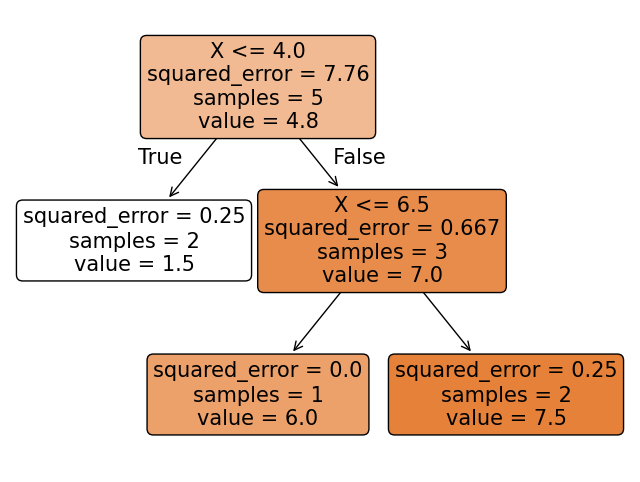

In [7]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Prepare the data (feature and label are the same).
X = np.array([1, 2, 6, 7, 8]).reshape(-1, 1)
y = np.array([1, 2, 6, 7, 8])

# Build the decision tree regressor.
model = DecisionTreeRegressor(max_leaf_nodes=3)
model.fit(X, y)

# Visualize the tree.
plt.figure(figsize=(8,6))
plot_tree(model, feature_names=['X'], filled=True, rounded=True)
plt.show()

As we can see it does not use first method and the output is the same as in the formulation of second and third method.